In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

###
# Recreation of Jegadessh and Titman's (1993) momentum strategy
# Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency
# based on current stock price data.
# This script implements a momentum-based trading strategy using stock price data.
###

# Parameters
lookback_months = 6  # J = x months
holding_months = 6   # K = x months
data_dir = Path("stock_info")
price_data = {}

# Load stock price data
for file in data_dir.glob("*.csv"):
    try:
        df = pd.read_csv(file, parse_dates=["Date"])
        df["Close/Last"] = df["Close/Last"].replace('[\$,]', '', regex=True).astype(float)
        df = df.sort_values("Date").set_index("Date")
        price_data[file.stem] = df["Close/Last"]
    except Exception as e:
        print(f"Failed to load {file.name}: {e}")

# Combine price data
prices = pd.DataFrame(price_data)
prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()

# Resample to monthly frequency (month-end prices)
monthly_prices = prices.resample("M").last()

# Drop stocks with too much missing data
monthly_prices = monthly_prices.dropna(axis=1, thresh=int(0.8 * len(monthly_prices)))

# Calculate monthly returns
monthly_returns = monthly_prices.pct_change().dropna()

# Future returns for holding period (K-month forward returns)
future_returns = monthly_prices.pct_change(periods=holding_months).shift(-holding_months)

# Rebalance dates (month-ends after the lookback period)
rebalance_dates = monthly_returns.index[lookback_months:-holding_months]

# Store portfolios and returns
active_portfolios = []
portfolio_returns = defaultdict(list)

<>:25: SyntaxWarning: invalid escape sequence '\$'
<>:25: SyntaxWarning: invalid escape sequence '\$'
C:\Users\NickPC\AppData\Local\Temp\ipykernel_19760\549487731.py:25: SyntaxWarning: invalid escape sequence '\$'
  df["Close/Last"] = df["Close/Last"].replace('[\$,]', '', regex=True).astype(float)
C:\Users\NickPC\AppData\Local\Temp\ipykernel_19760\549487731.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = prices.resample("M").last()


In [17]:
for date in rebalance_dates:
    try:
        # Price change over past J months, skipping the most recent month
        start_date = monthly_prices.index[monthly_prices.index.get_loc(date) - lookback_months - 1]
        end_date = monthly_prices.index[monthly_prices.index.get_loc(date) - 1]

        past_price = monthly_prices.loc[start_date]
        recent_price = monthly_prices.loc[end_date]

        # Calculate momentum scores
        momentum_scores = (recent_price / past_price) - 1
        momentum_scores = momentum_scores.dropna()

        # Rank scores and cut by deciles
        ranked = momentum_scores.rank(pct=True)
        deciles = pd.qcut(ranked, 10, labels=False)

        future_date = monthly_prices.index[monthly_prices.index.get_loc(date) + holding_months]
        if future_date not in future_returns.index:
            print(f"Skipping {date.date()}: future return not available.")
            continue

        # Assign stocks to deciles
        for decile in range(10):
            stocks = momentum_scores.index[deciles == decile]
            if len(stocks) == 0:
                continue

            active_portfolios.append({
                "start_date": date,
                "end_date": future_date,
                "decile": decile + 1,
                "stocks": stocks
            })

        # Calculate return for each active portfolio on this rebalance date
        for port in active_portfolios[:]:
            if date >= port["end_date"]:
                active_portfolios.remove(port)
                continue

            valid_stocks = [s for s in port["stocks"] if s in future_returns.columns]
            if not valid_stocks or date not in future_returns.index:
                continue

            monthly_return = future_returns.loc[date, valid_stocks].mean()
            portfolio_returns[(date, port["decile"])].append(monthly_return)

    except Exception as e:
        print(f"Error on {date.date()}: {e}")

# Average overlapping returns
final_data = []
for (date, decile), rets in portfolio_returns.items():
    final_data.append({
        "Date": date,
        "Decile": decile,
        "Return": np.mean(rets)
    })

portfolio_df = pd.DataFrame(final_data)
portfolio_df = portfolio_df.sort_values("Date")

# Calculate cumulative returns for plotting
portfolio_df["Cumulative Return"] = (
    portfolio_df.groupby("Decile")["Return"]
    .transform(lambda x: (1 + x).cumprod())
)

# Save to CSV
Path("output").mkdir(parents=True, exist_ok=True)
portfolio_df.to_csv("output/momentum_portfolio_returns_monthly.csv", index=False)

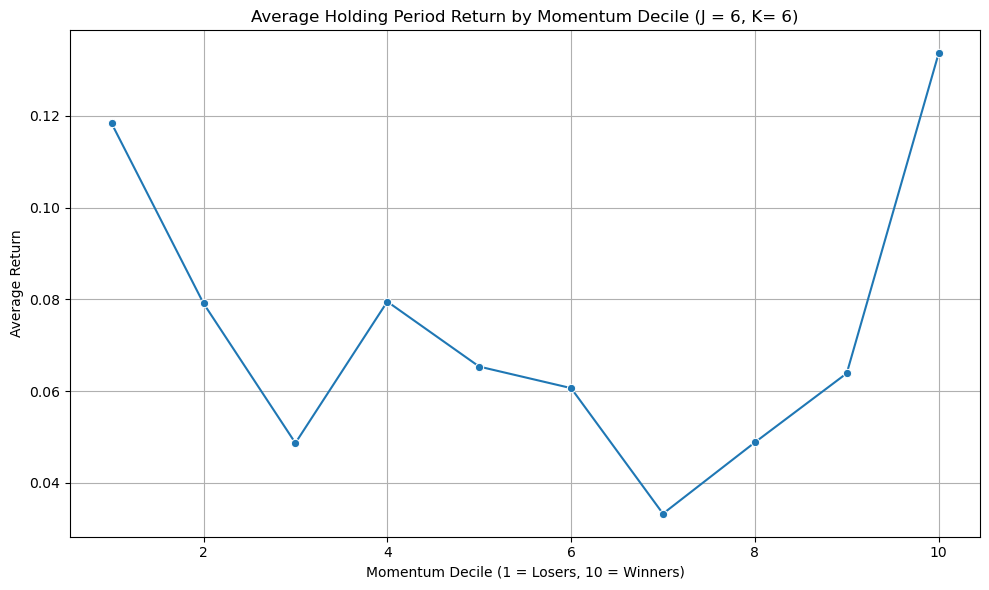

In [18]:
# Plot average return per decile
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=portfolio_df.groupby("Decile")["Return"].mean().reset_index(),
    x="Decile", y="Return", marker="o"
)
plt.title(f"Average Holding Period Return by Momentum Decile (J = {lookback_months}, K= {holding_months})")
plt.xlabel("Momentum Decile (1 = Losers, 10 = Winners)")
plt.ylabel("Average Return")
plt.grid(True)
plt.tight_layout()
plt.show()

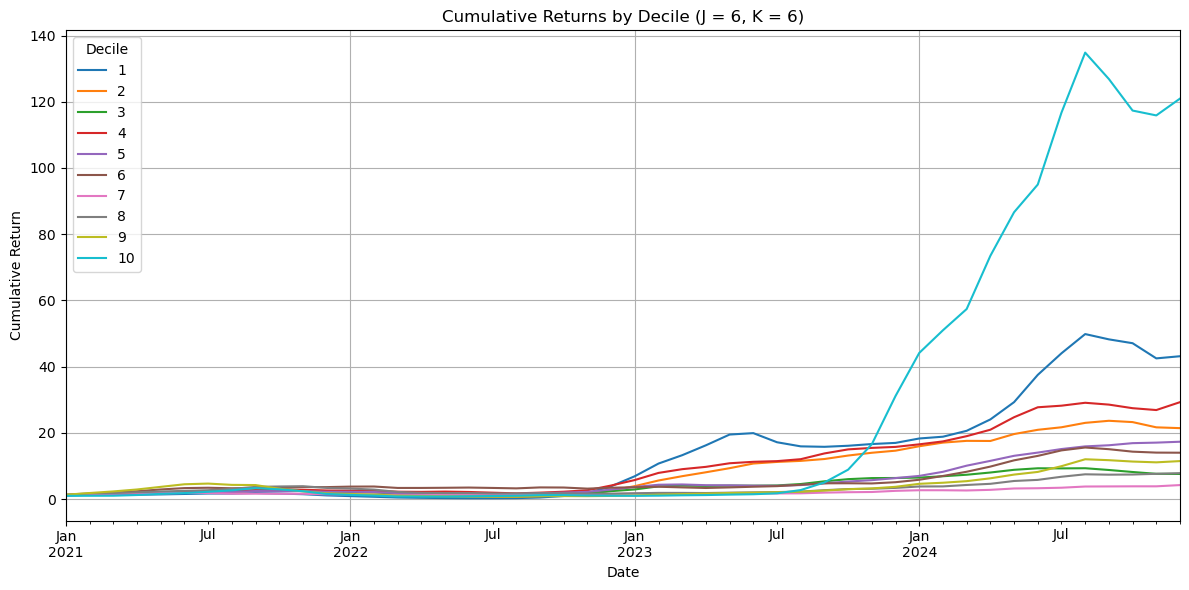

In [19]:
# Plot cumulative returns by decile
cumulative_returns = (
    portfolio_df.pivot(index="Date", columns="Decile", values="Return")
    .fillna(0)
    .add(1).cumprod()
)

cumulative_returns.plot(figsize=(12, 6), colormap="tab10")
plt.title(f"Cumulative Returns by Decile (J = {lookback_months}, K = {holding_months})")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True)
plt.legend(title="Decile")
plt.tight_layout()
plt.show()

In [20]:
# To implement, heatmap of J = 3,6,9,12; K = 3,6,9,12 for returns based on values
# Sharpe ratio, drawdown?